In [1]:
# dataframe
import pandas as pd

# basic math and stats formulas and plots
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# model metrics validation
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.metrics import Recall
from sklearn.metrics import recall_score

# neural network
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras import optimizers

# Dataset transformation

In [2]:
df = pd.read_csv('torino.csv')
df = df.drop(['Unnamed: 0', 'cloud_cover', 'direction_bin'], axis = 1)
df['date']= pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')

We check the dataset because the LSTM model is used with homogeneous time series. We plotted the date_diff variable vs the date. So the date where there is a high peak tells us that there is a big gap in the time series.

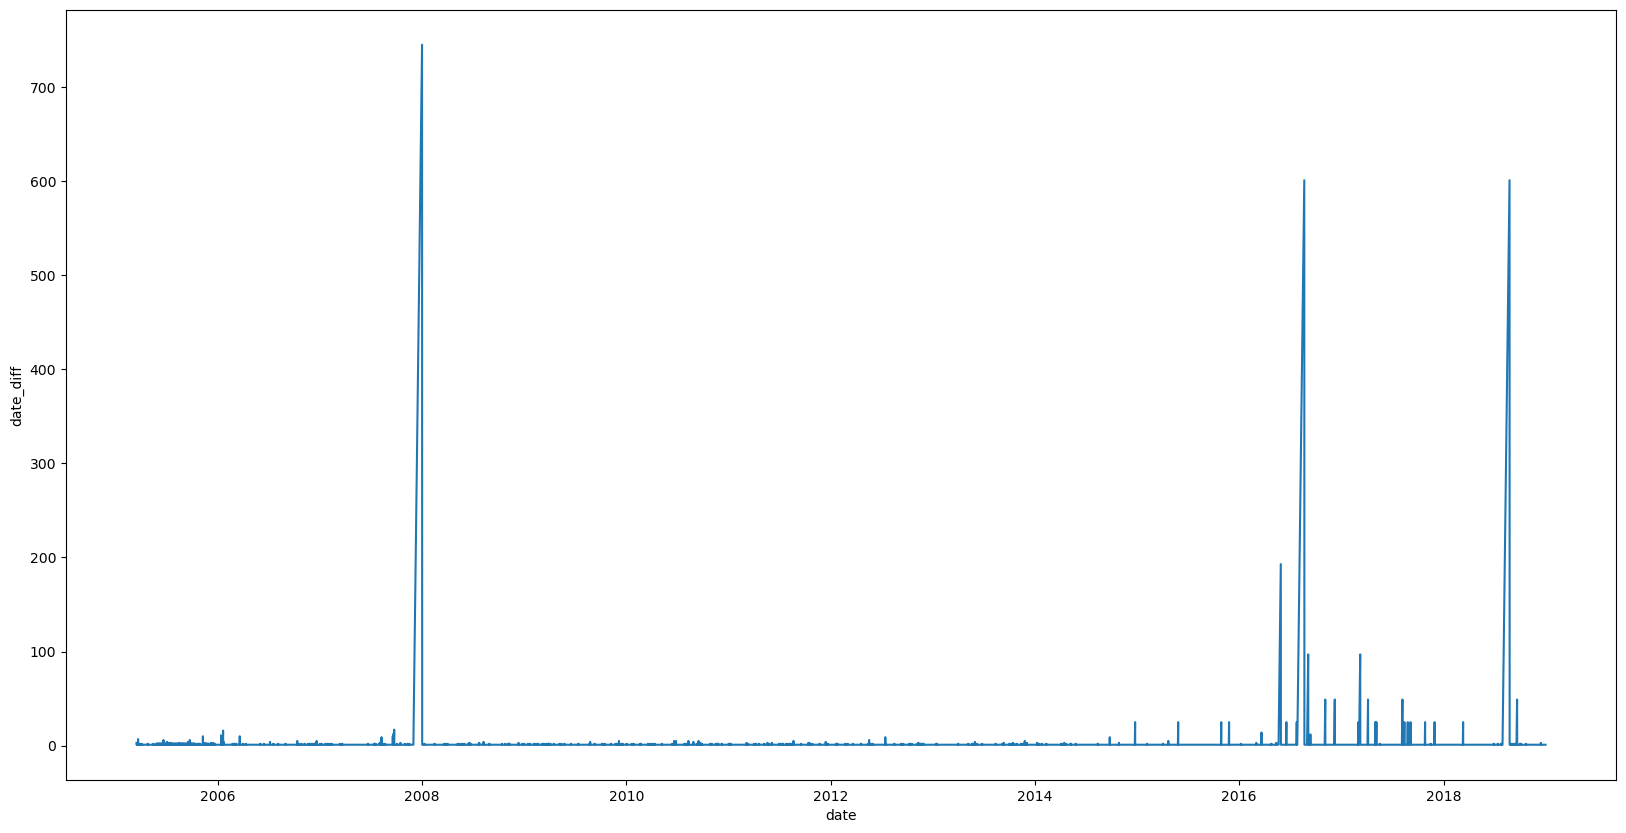

In [3]:
plt.figure(figsize = (20,10))
sns.lineplot(data = df, x = 'date', y = 'date_diff')
plt.show()

We can see that there is an enormous gap in 2008 and that from 2016 the time series is quite messy. So we use as date range 2013-09-01 and 2016-01-01. 

In [4]:
df = df[df['date'] >= pd.to_datetime("2013-09-01 00:00:00", format='%Y-%m-%d %H:%M:%S')]
df = df[df['date'] <= pd.to_datetime("2016-01-01 00:00:00", format='%Y-%m-%d %H:%M:%S')]

In [5]:
fog_cases = df[df['fog'] == 1].shape[0]
fog_pct = fog_cases * 100/df.shape[0]

print(f'The fog cases are {fog_cases} ({round(fog_pct, 2)}%)')

The fog cases are 2761 (13.61%)


In [6]:
# Resampling of time series to obtain hourly frequency
df2 = df.copy()
df2.index = df2['date']
df2 = df2.resample('1H').mean()
df2 = df2.drop(['Julian', 'date_diff', 'Month', 'Day', 'Hour', 'Year', 'present_weather', 'cloud_type', 'new_pres_weath'], axis = 1)

print(df2.shape)
df2.isna().sum()

(20449, 9)


pressure          161
wind_direction    161
wind_speed        161
visibility        161
past_weather1     161
past_weather2     161
drybulb           161
dewpoint          161
fog               161
dtype: int64

In [7]:
df1 = df2.copy()
df1 = df1.reset_index(drop = 1)

# Interpolation categorical
categorical = ['past_weather1', 'past_weather2']
df_cat = df1[categorical].copy()
df_cat = df_cat.interpolate(method = 'nearest')

# Interpolation numerical
numerical = ['pressure', 'wind_direction', 'wind_speed','drybulb', 'dewpoint', 'visibility']
df_num = df1[numerical].copy()
df_num = df_num.interpolate(method = 'linear')

In [8]:
# Save the target fog in the variable y

y = []

for i in list(df_num['visibility']):
    if i <= 1000:
        y.append(1)
    else:
        y.append(0)

df_num_ = df_num.drop('visibility', axis = 1)

In [9]:
# Scaling numerical
scaler = StandardScaler()  
df_num1 = scaler.fit_transform(df_num_)
df_num1 = pd.DataFrame(df_num1, columns = df_num_.columns.values)

# Transforming categorical
df_cat1 = pd.get_dummies(df_cat, columns = df_cat.columns.values)

# Merging categorical and numerical
dfNN = pd.concat([df_cat1, df_num1], axis = 1)
dfNN['fog'] = y
dfNN.index = df2.index
print(dfNN.shape)
dfNN.isna().sum()

(20449, 26)


past_weather1_0.0    0
past_weather1_1.0    0
past_weather1_2.0    0
past_weather1_3.0    0
past_weather1_4.0    0
past_weather1_5.0    0
past_weather1_6.0    0
past_weather1_7.0    0
past_weather1_8.0    0
past_weather1_9.0    0
past_weather2_0.0    0
past_weather2_1.0    0
past_weather2_2.0    0
past_weather2_3.0    0
past_weather2_4.0    0
past_weather2_5.0    0
past_weather2_6.0    0
past_weather2_7.0    0
past_weather2_8.0    0
past_weather2_9.0    0
pressure             0
wind_direction       0
wind_speed           0
drybulb              0
dewpoint             0
fog                  0
dtype: int64

# Splitting
Now we can split the time series in training set and testing set with the splitting date at 2015-09-01. Obviously we build also a validation set using as splitting date 2015-06-01 (so we add 3 months to the test)

In [10]:
test_date = pd.to_datetime("2015-09-01 00:00:00", format='%Y-%m-%d %H:%M:%S')
val_date = pd.to_datetime("2015-06-01 00:00:00", format='%Y-%m-%d %H:%M:%S')

# Creation of training, validation, testing set
train = dfNN[dfNN.index <= test_date]
val =  dfNN[dfNN.index >= val_date]
test = dfNN[dfNN.index > test_date]


# Visualization of datasets shapes, fog cases and percentages
pct_train = train[train['fog'] == 1].shape[0] * 100 / train.shape[0] 
pct_val = val[val['fog'] == 1].shape[0] * 100 / val.shape[0] 
pct_test = test[test['fog'] == 1].shape[0] * 100 / test.shape[0] 

print(f'Training shape and fog percentage: {train.shape}, {round(pct_train,2)}%')
print(f'Validation shape and fog percentage: {val.shape}, {round(pct_val,2)}%')
print(f'Testing shape and fog percentage: {test.shape}, {round(pct_test,2)}%')

Training shape and fog percentage: (17521, 26), 14.53%
Validation shape and fog percentage: (5137, 26), 5.78%
Testing shape and fog percentage: (2928, 26), 7.79%


Here's a visualization of the split

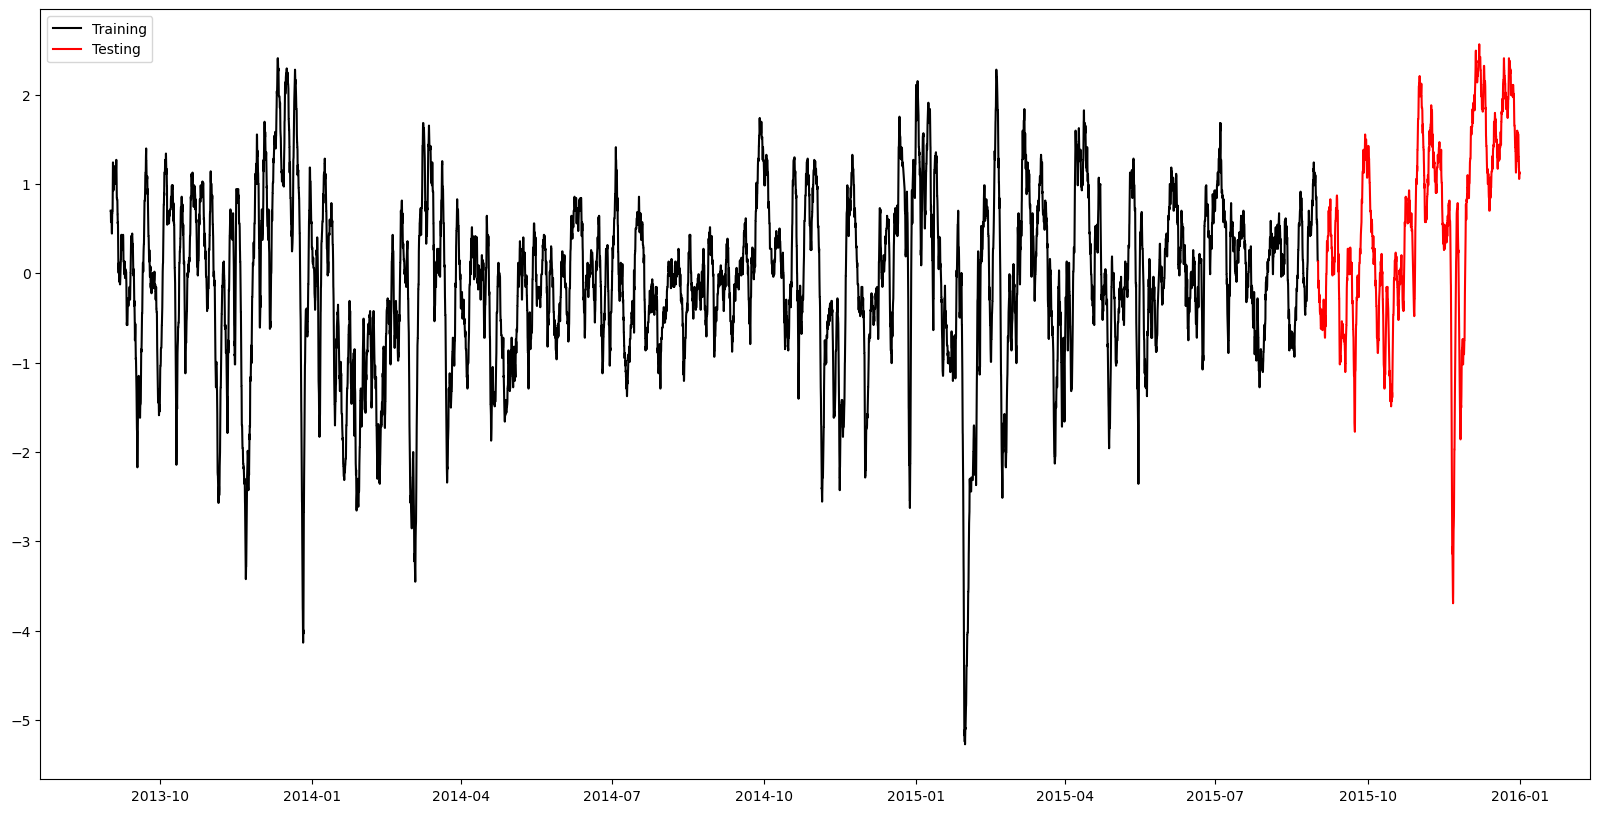

In [11]:
plt.figure(figsize = (20,10))
plt.plot(train.index, train['pressure'], color = 'black', label = 'Training')
plt.plot(test.index, test['pressure'], color = 'red', label = 'Testing')
plt.legend()
plt.show()

In [12]:
# Splitting all the sets in predictors and target
n_features = 25

X_train = train.drop('fog', axis = 1).values
y_train = train['fog'].values

X_val = val.drop('fog', axis = 1).values
y_val = val['fog'].values

X_test = test.drop('fog', axis = 1).values
y_test = test['fog'].values

# condition to read the csv file of results
condition=1


# Fine Tuning


For the training of the neural network we start with a hyperparameter tuning. The grid is:  

- number of neurons: 16, 32, 64
- activation function (of the hidden layer): relu, sigmoid, tanh
- optimizer: SGD, Adam, RMSprop, Adadelta
- batch_size: 8, 16, 32
- hops: 10, 20, 30

Being a binary classification the activation function of the last layer is set to sigmoid and the loss function is the binary crossentropy.   
The metrics considered apart from the loss are accuracy and recall. We added the recall because the dataset is imbalanced so the accuracy is "falsely" high. So if we use the recall we know how many fog cases are predicted respect to the true number of fog cases.  
At this neural network we added a callback. Basically if the recall on the validation set doesn't increase for 10 epochs the neural network is forced to stop.  
For every set of parameters is stored the accuracy and the recall of the predictions on the test set.

In [13]:
activationL = ['relu', 'sigmoid', 'tanh']
results = []
counter = 0

# for neurons in [16, 32, 64]:
#     for activation in activationL:
#         for opt in ['SGD', 'Adam', 'RMSprop', 'Adadelta']:
#             for batch_size in [8, 16, 32]:
#                 for hops in [10, 20, 30]:

#                     np.random.seed(1)

#                     print('*' * 50)
#                     print('Parameters:')
#                     print(f'No. neurons: {neurons}')
#                     print(f'Activation: {activation}')
#                     print(f'Optimizer: {opt}')
#                     print(f'Batch size: {batch_size}')
#                     print(f'Hops: {hops}')


#                     # Creation of training set for LSTM
#                     X_train_lstm = []
#                     y_train_lstm = []

#                     for i in range(hops, len(y_train)):
#                         X_train_lstm.append(X_train[i-hops:i])
#                         y_train_lstm.append(y_train[i])

#                     X_train_lstm, y_train_lstm = np.array(X_train_lstm), np.array(y_train_lstm)
#                     X_train_def = np.reshape(X_train_lstm, (X_train_lstm.shape[0], X_train_lstm.shape[1], X_train_lstm.shape[2]))

#                     # Creation of validation set for LSTM
#                     X_val_lstm = []
#                     y_val_lstm = []

#                     for i in range(hops, len(y_val)):
#                         X_val_lstm.append(X_val[i-hops:i])
#                         y_val_lstm.append(y_val[i])

#                     X_val_lstm, y_val_lstm = np.array(X_val_lstm), np.array(y_val_lstm)
#                     X_val_def = np.reshape(X_val_lstm, (X_val_lstm.shape[0], X_val_lstm.shape[1], X_val_lstm.shape[2]))

#                     # Creation of testing set for LSTM
#                     X_test_lstm = []
#                     y_test_lstm = []

#                     for i in range(hops, len(y_test)):
#                         X_test_lstm.append(X_test[i-hops:i])
#                         y_test_lstm.append(y_test[i])

#                     X_test_lstm, y_test_lstm = np.array(X_test_lstm), np.array(y_test_lstm)
#                     X_test_def = np.reshape(X_test_lstm, (X_test_lstm.shape[0], X_test_lstm.shape[1], X_test_lstm.shape[2]))

#                     # Creation of the model
#                     model = Sequential()
#                     model.add(LSTM(units = neurons, input_shape = (hops, n_features), activation=activation))
#                     model.add(Dense(1, activation='sigmoid'))
#                     model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.Recall()])
                    
#                     # Condition of early stopping by monitoring the recall on the validation set
#                     if counter == 0:
#                         es = EarlyStopping(monitor='val_recall', 
#                                                         mode='max',
#                                                         patience=25,
#                                                         restore_best_weights=True)
#                     else:
#                         es = EarlyStopping(monitor=f'val_recall_{counter}', 
#                                                         mode='max',
#                                                         patience=25,
#                                                         restore_best_weights=True)

#                     counter += 1

#                     # LSTM fitting
#                     history = model.fit(X_train_def, y_train_lstm, epochs = 100, batch_size=batch_size, verbose = 1, validation_data = (X_val_def, y_val_lstm), callbacks = [es])

#                     # Predictions of the model on the test set
#                     preds = np.round(model.predict(X_test_def),0)
                    
#                     # Storing the metrics (accuracy, recall) on the test set in a list
#                     try:
#                         score1 = recall_score(y_test_lstm, preds, pos_label=1)
#                         score2 = accuracy_score(y_test_lstm, preds)
#                     except:
#                         score1, score2 = 0,0
#                     params = [neurons, activation, batch_size, opt, hops, score1, score2]
#                     results.append(params)
# condition = 0

To select the parameters with best performances we take the parameters that bring to the best accuracy but also the parameters that bring to the best accuracy + recall.

In [14]:
if condition==0:
    results_df=pd.DataFrame(results,columns=['neurons', 'activation', 'batch_size', 'opt', 'hops', 'score1', 'score2'])
    results_df.to_csv('LSTM_torinoTuning.csv',index=False)
else:
    results_df=pd.read_csv('LSTM_torinoTuning.csv')
    results = list(results_df.values)

# Best model selection

In [15]:
mix = [x[5] + x[6] for x in results]
best_mix_ind = mix.index(np.max(mix))
best_mix = results[best_mix_ind]

accuracies = [x[6] for x in results]
best_acc_ind = accuracies.index(np.max(accuracies))
best_acc = results[best_acc_ind]

print(f'Best accuracy + recall: {best_mix}')
print(f'Best accuracy: {best_acc}')

Best accuracy + recall: [16 'relu' 8 'RMSprop' 20 0.8947368421052632 0.9508253094910591]
Best accuracy: [16 'relu' 8 'SGD' 10 0.8289473684210527 0.9708704592186428]


We run again the best model to plot the results.

In [16]:
np.random.seed(1)

if condition == 1:
    metric = 'val_recall'
else:
    metric = f'val_recall_{counter}'


neurons, activation, batch_size, opt, hops = best_mix[0], best_mix[1], best_mix[2], best_mix[3], best_mix[4]

# Creation of training set for LSTM
X_train_lstm = []
y_train_lstm = []

for i in range(hops, len(y_train)):
    X_train_lstm.append(X_train[i-hops:i])
    y_train_lstm.append(y_train[i])

X_train_lstm, y_train_lstm = np.array(X_train_lstm), np.array(y_train_lstm)
X_train_def = np.reshape(X_train_lstm, (X_train_lstm.shape[0], X_train_lstm.shape[1], X_train_lstm.shape[2]))

# Creation of validation set for LSTM
X_val_lstm = []
y_val_lstm = []

for i in range(hops, len(y_val)):
    X_val_lstm.append(X_val[i-hops:i])
    y_val_lstm.append(y_val[i])

X_val_lstm, y_val_lstm = np.array(X_val_lstm), np.array(y_val_lstm)
X_val_def = np.reshape(X_val_lstm, (X_val_lstm.shape[0], X_val_lstm.shape[1], X_val_lstm.shape[2]))

# Creation of testing set for LSTM
X_test_lstm = []
y_test_lstm = []

for i in range(hops, len(y_test)):
    X_test_lstm.append(X_test[i-hops:i])
    y_test_lstm.append(y_test[i])

X_test_lstm, y_test_lstm = np.array(X_test_lstm), np.array(y_test_lstm)
X_test_def = np.reshape(X_test_lstm, (X_test_lstm.shape[0], X_test_lstm.shape[1], X_test_lstm.shape[2]))

# Creation of the model
model = Sequential()
model.add(LSTM(units = neurons, input_shape = (hops, n_features), activation=activation))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.Recall()])

# Condition of early stopping by monitoring the recall on the validation set
es = EarlyStopping(monitor=metric, 
                                mode='max',
                                patience=25,
                                restore_best_weights=True)

# Fitting the model and storing all metrics in the variable history
history = model.fit(X_train_def, y_train_lstm, epochs = 100, batch_size=batch_size, verbose = 1, validation_data = (X_val_def, y_val_lstm), callbacks = [es])

Epoch 1/100
2188/2188 [==============================] - 9s 4ms/step - loss: 0.1752 - accuracy: 0.9405 - recall: 0.7870 - val_loss: 0.0840 - val_accuracy: 0.9705 - val_recall: 0.6768
Epoch 2/100
2188/2188 [==============================] - 8s 4ms/step - loss: 0.1364 - accuracy: 0.9529 - recall: 0.8428 - val_loss: 0.0923 - val_accuracy: 0.9695 - val_recall: 0.6700
Epoch 3/100
2188/2188 [==============================] - 8s 4ms/step - loss: 0.1338 - accuracy: 0.9549 - recall: 0.8483 - val_loss: 0.1702 - val_accuracy: 0.9648 - val_recall: 0.6902
Epoch 4/100
2188/2188 [==============================] - 8s 4ms/step - loss: 0.1489 - accuracy: 0.9554 - recall: 0.8479 - val_loss: 0.1374 - val_accuracy: 0.9660 - val_recall: 0.7003
Epoch 5/100
2188/2188 [==============================] - 8s 4ms/step - loss: 0.1423 - accuracy: 0.9562 - recall: 0.8472 - val_loss: 0.1009 - val_accuracy: 0.9695 - val_recall: 0.7003
Epoch 6/100
2188/2188 [==============================] - 8s 4ms/step - loss: 0.1389 -

# Performances

In [17]:
def predictions_results(X, y, model):
    preds = np.round(model.predict(X),0)

    # Measure recall and accuracy of the prediction
    score1 = recall_score(y, preds, pos_label=1)
    score2 = accuracy_score(y, preds)
    # Plotting the metrics, classification report and the confusion matrix

    print(f'Accuracy: {round(score2 * 100, 2)}')
    print(f'Recall: {round(score1 * 100, 2)}')

    cm = confusion_matrix(y, preds)
    disp = ConfusionMatrixDisplay(cm)
    print(classification_report(y, preds))
    disp.plot()
    plt.show()

### Validation

160/160 [==============================] - 1s 3ms/step
Accuracy: 97.07
Recall: 78.79
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      4820
           1       0.73      0.79      0.76       297

    accuracy                           0.97      5117
   macro avg       0.86      0.88      0.87      5117
weighted avg       0.97      0.97      0.97      5117



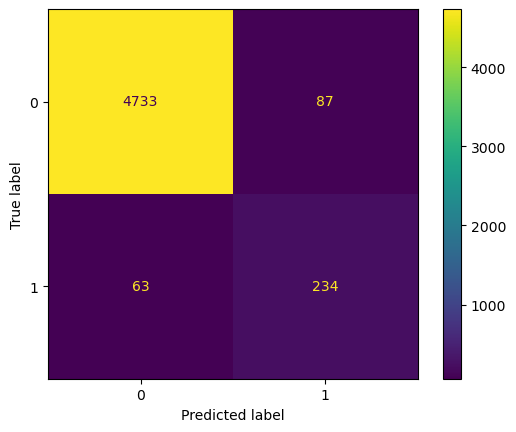

In [18]:
predictions_results(X_val_def, y_val_lstm, model)

### Test

91/91 [==============================] - 0s 3ms/step
Accuracy: 96.49
Recall: 81.58
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2680
           1       0.76      0.82      0.78       228

    accuracy                           0.96      2908
   macro avg       0.87      0.90      0.88      2908
weighted avg       0.97      0.96      0.97      2908



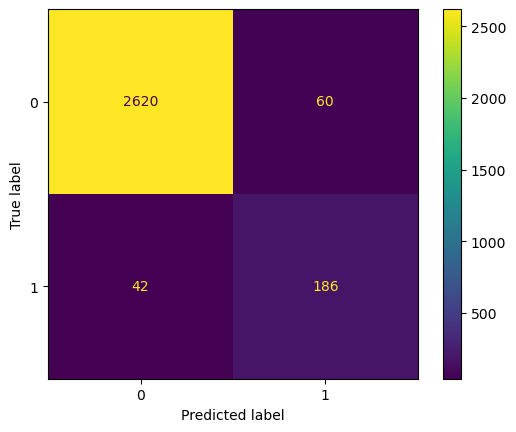

In [19]:
predictions_results(X_test_def, y_test_lstm, model)

### Metrics

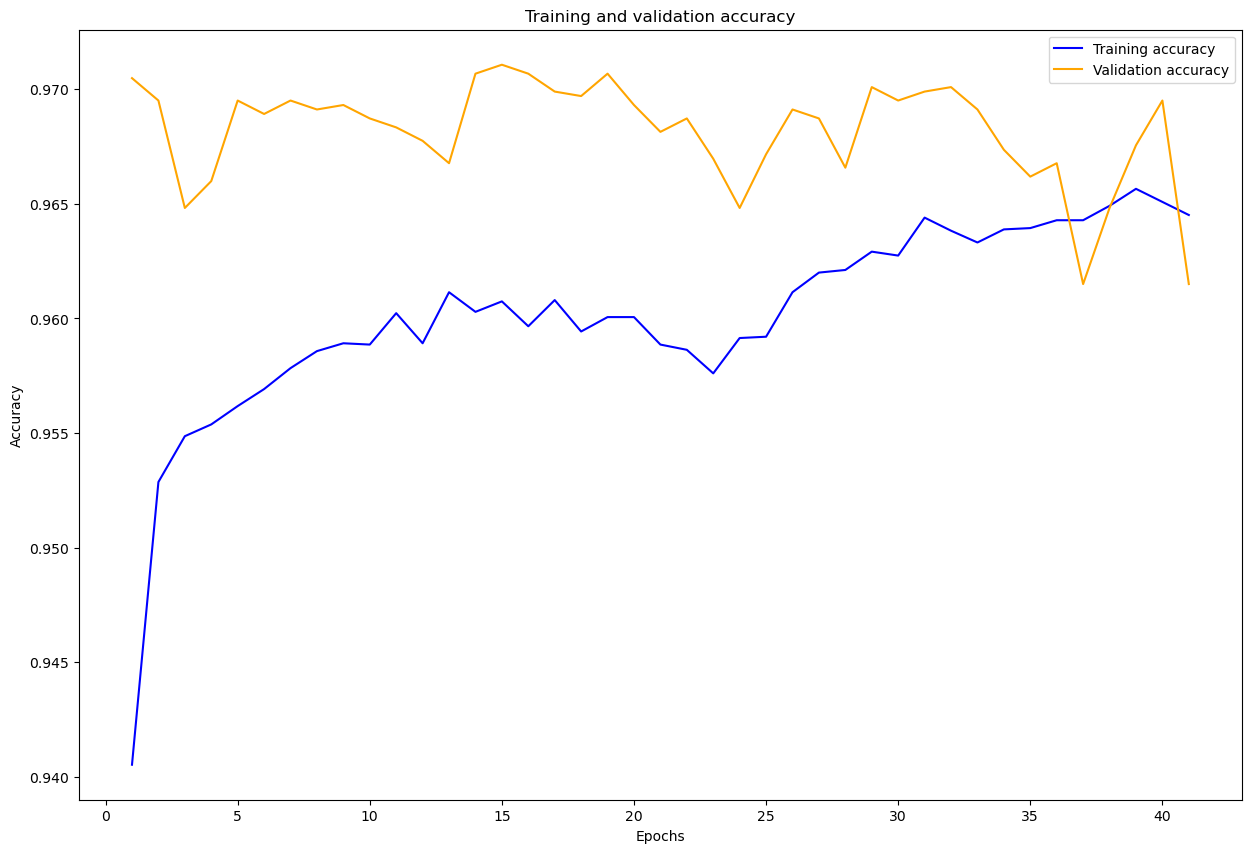

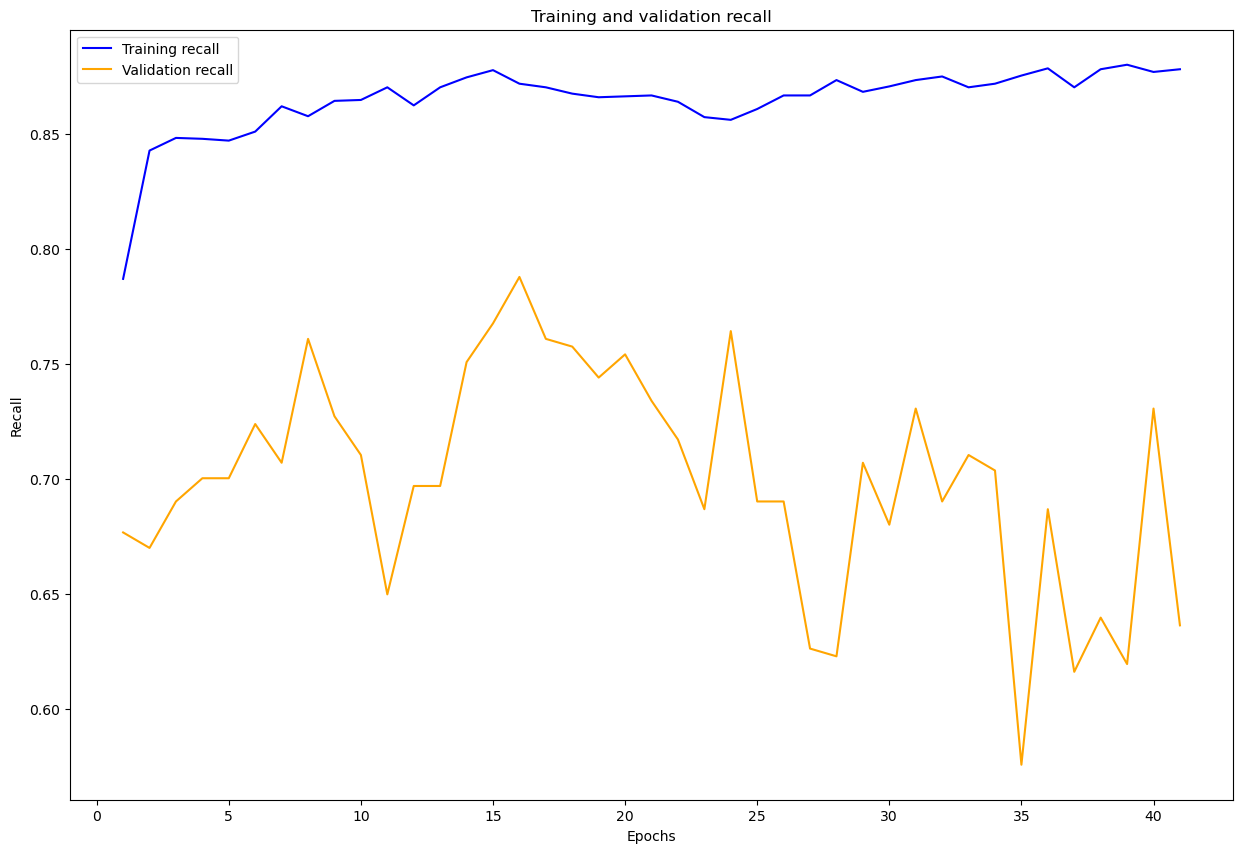

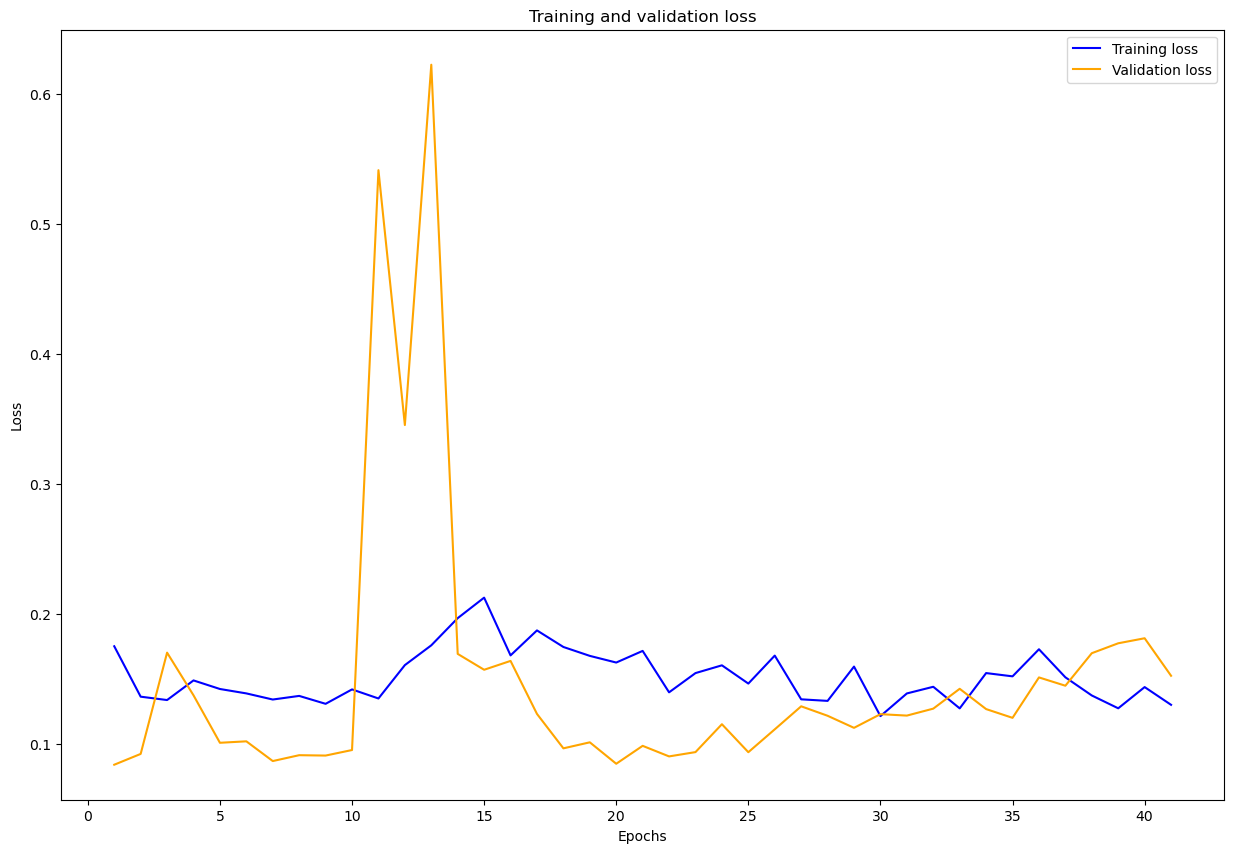

In [20]:
history_dict = history.history

# Loss
rec = history_dict[metric[4:]]
val_rec = history_dict[metric]

# Loss
acc = history_dict[f'accuracy']
val_acc = history_dict[f'val_accuracy']

# Accuracy
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(val_loss) + 1) 

# Plotting accuracy
plt.figure(figsize = (15,10))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting recall
plt.figure(figsize = (15,10))
plt.plot(epochs, rec, 'b', label='Training recall')
plt.plot(epochs, val_rec, 'orange', label='Validation recall')
plt.title('Training and validation recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()


# Plotting loss
plt.figure(figsize = (15,10))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()